In [5]:
from music21 import *
import numpy
import pandas as pd
from music21 import audioSearch as audioSearchBase

In [7]:
def runTranscribe(show, plot, useMic, audioFile,
                  seconds, useScale, saveFile):
    '''
    runs all the methods to record from audio for `seconds` length (default 10.0)
    and transcribe the resulting melody returning a music21.Score object
    
    if `show` is True, show the stream.  
    
    if `plot` is True then a Tk graph of the frequencies will be displayed.

    'audioFile' is a filepath to recorded audio to use instead of the mic if usemic is false
    
    if `useMic` is True then use the microphone.  If False it will load the file of `saveFile`
    or the default temp file to run transcriptions from.
        
    a different scale besides the chromatic scale can be specified by setting `useScale`.
    See :ref:`moduleScale` for a list of allowable scales. (or a custom one can be given).
    Microtonal scales are totally accepted, as are retuned scales where A != 440hz.

    if `saveFile` is False then then the recorded audio is saved to disk.  If
    set to `True` then `environLocal.getRootTempDir() + os.path.sep + 'ex.wav'` is
    used as the filename.  If set to anything else then it will use that as the
    filename. 
    '''

    if useScale is None:
        useScale = scale.ChromaticScale('C4')
    #beginning - recording or not
    if saveFile == True:
        WAVE_FILENAME = 'score.mxl'
    
    # the rest of the score
    if useMic is True:
        freqFromAQList = audioSearchBase.getFrequenciesFromMicrophone(length=seconds, storeWaveFilename=WAVE_FILENAME)
    else:
        freqFromAQList = audioSearchBase.getFrequenciesFromAudioFile(waveFilename=audioFile)
        
    detectedPitchesFreq = audioSearchBase.detectPitchFrequencies(freqFromAQList, useScale)
    detectedPitchesFreq = audioSearchBase.smoothFrequencies(detectedPitchesFreq)
    (detectedPitchObjects, listplot) = audioSearchBase.pitchFrequenciesToObjects(detectedPitchesFreq, useScale)
    (notesList, durationList) = audioSearchBase.joinConsecutiveIdenticalPitches(detectedPitchObjects)
    myScore, unused_length_part = audioSearchBase.notesAndDurationsToStream(notesList, durationList, removeRestsAtBeginning=True)    

    # This shows the score in MuseScore
    if show == True:
        myScore.show()        
    
    if plot == True:
        try:
            import matplotlib.pyplot # for find
        except ImportError:
            raise audioSearchBase.AudioSearchException("Cannot plot without matplotlib installed.")
        matplotlib.pyplot.plot(listplot)
        matplotlib.pyplot.show()
    print("END")    
        
    return myScore



In [59]:

# NOTE: This does not account for changing tempo (like the example does --> So it is wrong...) but it is not a hard fix.

def scoreToDataFrame(score):
    
    if type(score) != stream.PartStaff: #seems to be some differences between PartStaff and Part score types.
        return
    
    dur_beats_list = []
    dur_seconds_list = []
    freq_list = []
    name_list = []
    start_time_list = []

    length = score.metronomeMarkBoundaries()[0][2].numberSounding #quarter notes per minute 
    if length == None:
        length = score.metronomeMarkBoundaries()[0][2].number
    #Note, this up to offset 420.
    qps = 60 / int(length) #quarter notes per second
    
    
    content = score.getElementsByClass('Measure')
    
    for measure in content:
        for n in measure.notesAndRests:
            print(n)
            if (type(n) == chord.Chord):
               
                for my_note in n:
                    #print(note)
                    name = my_note.nameWithOctave
                    freq = my_note.pitch.frequency
                    dur_seconds = my_note.duration.quarterLength * qps
                    dur_beats = my_note.duration.type
                    start_time = (measure.offset + n.offset) * qps #in seconds
                    # note: This is calculated differently than above because the measure.offset gives the offset of the beginning of the measure.
                    
                    dur_beats_list.append(dur_beats)
                    dur_seconds_list.append(dur_seconds)
                    name_list.append(name)
                    freq_list.append(freq)
                    start_time_list.append(start_time)
            elif (type(n) == note.Rest):
                name = n.name
                freq = 0
                dur_seconds = n.duration.quarterLength * qps
                dur_beats = n.duration.type
                start_time = (measure.offset + n.offset) * qps
                
                dur_beats_list.append(dur_beats)
                dur_seconds_list.append(dur_seconds)
                name_list.append(name)
                freq_list.append(freq)
                start_time_list.append(start_time)
            else:
                print(type(n))
    dict_temp = {'Duration in Beats': dur_beats_list, 'Duration in Seconds': dur_seconds_list, 'Name': name_list, 'Frequency': freq_list, 'Start Time in Seconds': start_time_list}
    df = pd.DataFrame(data=dict_temp)
    
    return df

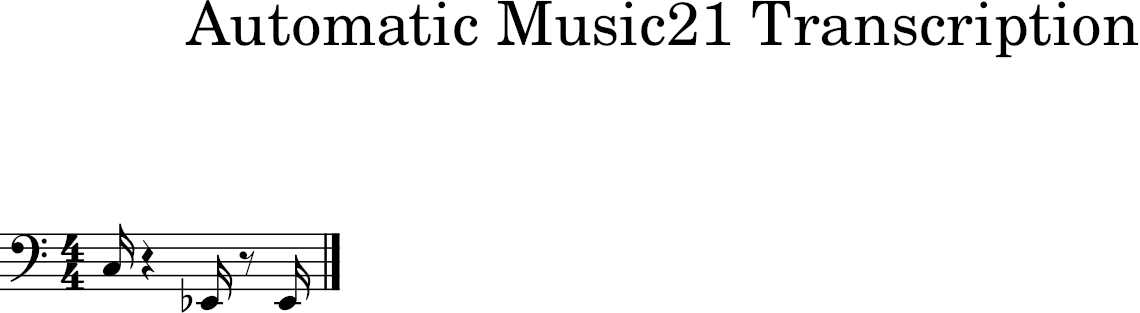

END


In [10]:
# This runs the function with specificed parameters
# Output is based on playing eqt-major-sc.wav from my phone
score = runTranscribe(show=True, plot=False, useMic=True, audioFile='',
                  seconds=10.0, useScale=None, saveFile=True)

In [33]:
hold = score.chordify()

#score
#print(score.length)

,Duration in Beats,Duration in Seconds,Name,Frequency,Start Time in Seconds


In [39]:
for h in hold.flatten():
    print(h)

<music21.chord.Chord C3>
<music21.note.Rest quarter>
<music21.chord.Chord E-2>
<music21.note.Rest eighth>
<music21.chord.Chord E-2>


In [53]:
hold

<music21.stream.Part 0x1a92a2dc2d0>

In [60]:
scoreToDataFrame(hold)

In [34]:
hold.show(fmt="musicxml")